In [1]:
# Libraries and packeges
import numpy as np
import pandas as pd
from matplotlib import collections as mc

# Visualize demand and candidate facility locations
import geopandas
from geopy.distance import lonlat, distance, great_circle, geodesic
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Optimization model related libraries
from gurobipy import *
from gurobipy import Model, GRB, quicksum
from itertools import product

# EDA

In [3]:
# Load Data
demand_points = pd.read_excel("Data/AllZipPop.xlsx")  # Customer demand points
candidate_locations = pd.read_excel("Data/FS_Location.xlsx") # Candidate facility locations
JC = geopandas.read_file("Data/Jefferson_County_KY_ZIP_Codes.shp")  # shapefile for mapping
display(demand_points.head())
display(candidate_locations.head())

,OBJECTID,ZIPCODE,longitude,latitude,pop
0,1,40023,-85.43959,38.18708,5925
1,2,40025,-85.64853,38.30431,460
2,3,40041,-85.66473,38.25629,361
3,4,40047,-85.57036,38.08056,21971
4,5,40059,-85.60583,38.33822,20205


,id,name,longitude,latitude
0,1,FS1,-85.785332,38.232840
1,2,FS2,-85.820118,38.164320
2,3,FS3,-85.646153,38.206096
3,4,FS4,-85.587143,38.283168
4,5,FS5,-85.554795,38.186315


In [4]:
# Add IDs and coordinates to the dataframe
demand_points['demand_id'] = range(1, 1 + demand_points.shape[0])
demand_points['dem_cor'] = demand_points['longitude'].astype(str) + ',' + demand_points['latitude'].astype(str)
demand_points['population'] = 400*(demand_points['pop'] - min(demand_points['pop']))/ (max(demand_points['pop'])-min(demand_points['pop']))

candidate_locations['candidate_id'] = ['Site' + str(i) for i in range(1, 1 + candidate_locations.shape[0])]
candidate_locations['fac_cor'] = candidate_locations['longitude'].astype(str) + ',' + candidate_locations['latitude'].astype(str)

In [5]:
demand_points.head()

,OBJECTID,ZIPCODE,longitude,latitude,pop,demand_id,dem_cor,population
0,1,40023,-85.43959,38.18708,5925,1,"-85.43959,38.18708",47.375367
1,2,40025,-85.64853,38.30431,460,2,"-85.64853,38.30431",0.842948
2,3,40041,-85.66473,38.25629,361,3,"-85.66473,38.25629",0.000000
3,4,40047,-85.57036,38.08056,21971,4,"-85.57036,38.08056",184.001022
4,5,40059,-85.60583,38.33822,20205,5,"-85.60583,38.33822",168.964196


In [6]:
# Create Geo-dataframe
def add_geocoordinates(demand_points, lng='longitude', lat='latitude'):
    assert pd.Series([lng, lat]).isin(demand_points.columns).all(),\
        f'Cannot find columns "{lng}" and/or "{lat}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        demand_points, geometry=geopandas.points_from_xy(demand_points.longitude, demand_points.latitude))

demand_points = add_geocoordinates(demand_points)
candidate_locations = add_geocoordinates(candidate_locations)


# Data visualization

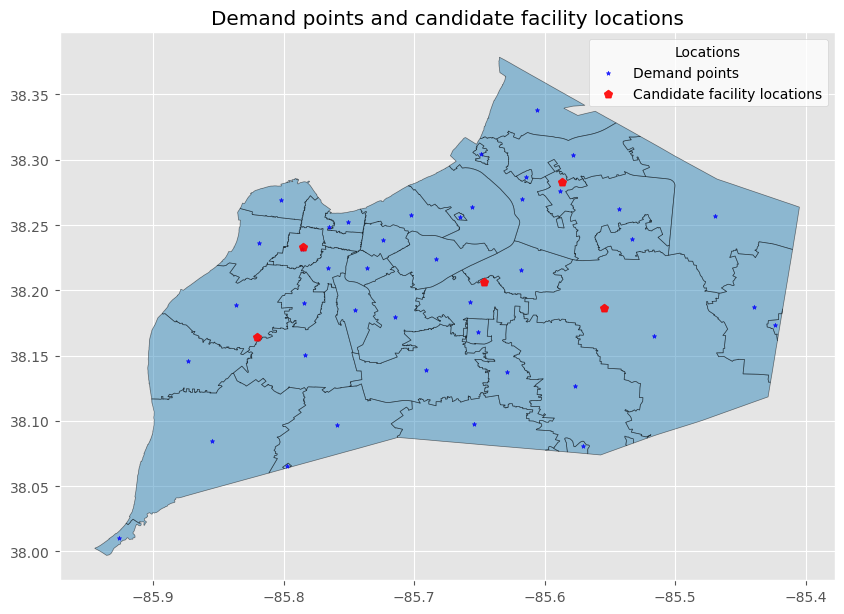

In [31]:
# Plot demand points and candidate facility locations
ax = JC.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
demand_points.plot(ax=ax, marker='*', color='blue', markersize=10, alpha=0.8, label='Demand points')
candidate_locations.plot(ax=ax, marker='p', color='red', markersize=40, alpha=0.9, label='Candidate facility locations')

plt.legend(facecolor='white', title='Locations')
plt.title('Demand points and candidate facility locations')
plt.savefig('initial.png')

# Optimization Models

In [8]:
#Parameters
I = [i for i in range(0, 42)]  # demand points                                    
J = [j for j in range(0, 5)]   # candidate facility locations

p = round(demand_points['pop']) # No. of population
Fac_cor = candidate_locations['fac_cor']
Dem_cor = demand_points['dem_cor']
A = [(i,j) for i in I for j in J]                                   
d_ij = {(i,j): geodesic(Dem_cor[i],Fac_cor[j]).miles for i, j in A }  
d_max=10 # Max distance threshold
N = 2  # No. of facility to be opened within the Budget

# Model-1: Finding minimum required number of facilities (Set Covering)

In [9]:
# Model
mdl1 = Model('location')

#Decision Variables
x = mdl1.addVars(J, vtype=GRB.BINARY,name='x')

obj = quicksum(x[j] for j in J)
mdl1.setObjective(obj, sense=GRB.MINIMIZE)
mdl1.addConstrs(quicksum((d_ij[i,j] * x[j]) for j in J if d_ij[i,j] <= d_max) >= 1 for i in I)

mdl1.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-26
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5825U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 42 rows, 5 columns and 127 nonzeros
Model fingerprint: 0xefdd26ec
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 42 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.0000000

# Decision from Model-1

In [10]:
# Decision: which locations should select
decision1 = []
for var in mdl1.getVars():
    if "x" in var.varName:
        if var.xn > 0:
            decision1.append("yes")
        else:
            decision1.append("no")


decision_df1=pd.DataFrame(decision1, columns=["decisions1"])
candidate_locations_df1=pd.concat([candidate_locations, decision_df1], axis=1)

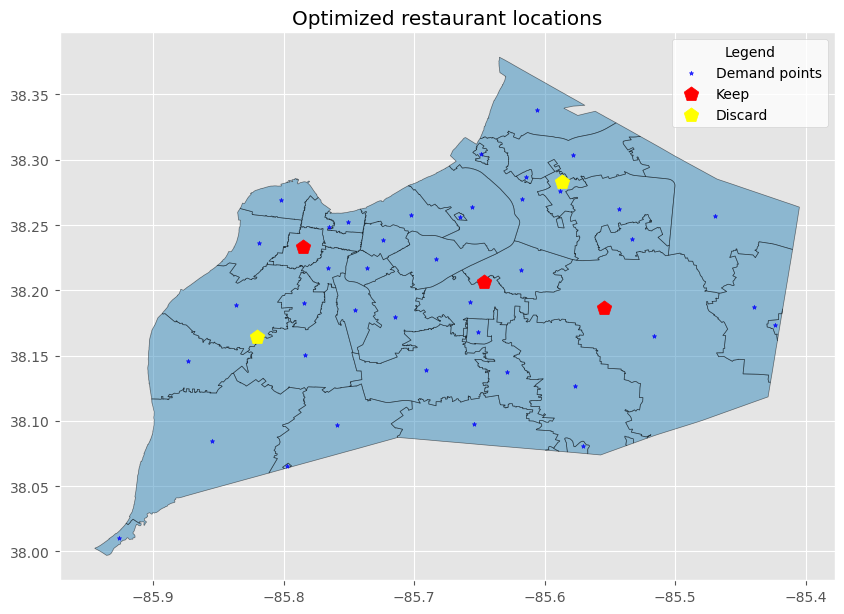

In [34]:
# Visualize the selected locations
ax = JC.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

demand_points.plot(ax=ax, marker='*', color='blue', markersize=10, alpha=0.8, label='Demand points')
candidate_locations_df1.loc[candidate_locations_df1.decisions1 =='yes'].\
    plot(ax=ax, marker='p', color='red', markersize=120, label='Keep')

candidate_locations_df1.loc[candidate_locations_df1.decisions1 =='no'].\
    plot(ax=ax, marker='p', color='yellow', markersize=120, label='Discard')

plt.title('Optimized restaurant locations')
plt.legend(title='Legend', facecolor='white')
#plt.xticks([])
#plt.yticks([])
#plt.show()
plt.savefig('model1.png')

# Model-2:Max Coverage Model

In [12]:
# Max covering Model
mdl2 = Model('location')

#Decision Variables
z = mdl2.addVars(I, vtype=GRB.BINARY,name='z')
x = mdl2.addVars(J, vtype=GRB.BINARY,name='x')

obj = quicksum(p[i]*(z[i]) for i in I)
mdl2.setObjective(obj, sense=GRB.MAXIMIZE)

mdl2.addConstrs(quicksum((d_ij[i,j] * x[j]) for j in J if d_ij[i,j] <= d_max) >= z[i] for i in I)
mdl2.addConstr(quicksum((x[j]) for j in J) == N)

mdl2.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5825U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 43 rows, 47 columns and 174 nonzeros
Model fingerprint: 0x1029eab1
Variable types: 0 continuous, 47 integer (47 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [4e+02, 5e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 811635.00000
Presolve removed 43 rows and 47 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 815444 811635 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.154440000000e+05, best bound 8.154440000000e+05, gap 0.0000%


# Decision from Model-2

In [13]:
decision2 = []
for var in mdl2.getVars():
    if "x" in var.varName:
        if var.xn > 0:
            decision2.append("yes")
        else:
            decision2.append("no")

decision_df2=pd.DataFrame(decision2, columns=["decisions2"])
candidate_locations_df2=pd.concat([candidate_locations, decision_df2], axis=1)

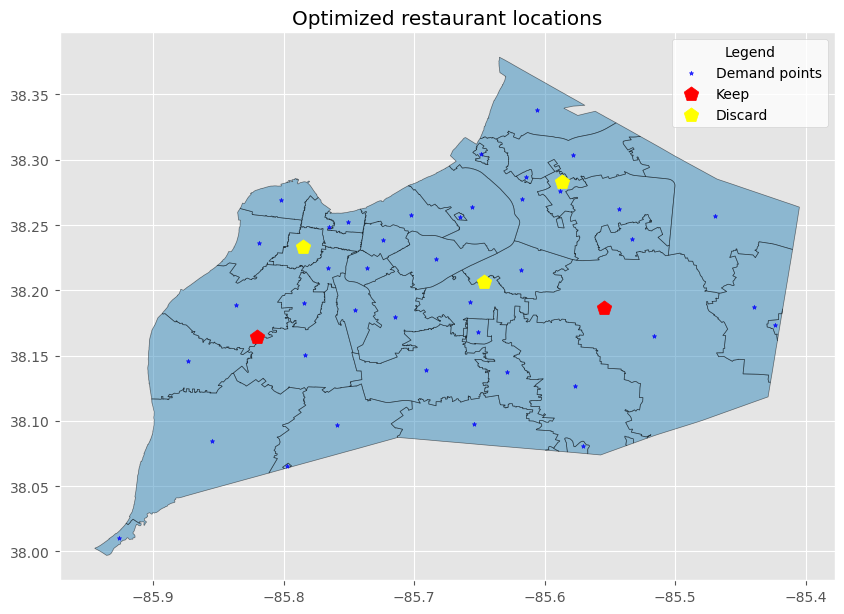

In [35]:
ax = JC.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

demand_points.plot(ax=ax, marker='*', color='blue', markersize=10, alpha=0.8, label='Demand points')
candidate_locations_df2.loc[candidate_locations_df2.decisions2 =='yes'].\
    plot(ax=ax, marker='p', color='red', markersize=120, label='Keep')

candidate_locations_df2.loc[candidate_locations_df2.decisions2 =='no'].\
    plot(ax=ax, marker='p', color='yellow', markersize=120, label='Discard')

plt.title('Optimized restaurant locations')
plt.legend(title='Legend', facecolor='white')
#plt.xticks([])
#plt.yticks([])
#plt.show()
plt.savefig('model2.png')

# Model-3: P-median model

In [15]:
# P-median Model
mdl3 = Model('location')

#Decision Variables
y = mdl3.addVars(I,J, vtype=GRB.BINARY,name='y')
x = mdl3.addVars(J, vtype=GRB.BINARY,name='x')

obj = quicksum(p[i]*d_ij[i,j]*(y[i,j]) for i in I for j in J)
mdl3.setObjective(obj, sense=GRB.MINIMIZE)

mdl3.addConstr(quicksum((x[j]) for j in J) == N)
mdl3.addConstrs(quicksum(y[i,j] for j in J) ==1 for i in I)
mdl3.addConstrs(y[i,j] <= x[j] for i in I for j in J)

mdl3.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5825U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 253 rows, 215 columns and 635 nonzeros
Model fingerprint: 0x64802b94
Variable types: 0 continuous, 215 integer (215 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 9e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 6273045.7335
Presolve time: 0.00s
Presolved: 253 rows, 215 columns, 635 nonzeros
Variable types: 0 continuous, 215 integer (215 binary)
Found heuristic solution: objective 3216592.1497

Root relaxation: objective 3.087366e+06, 124 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0

# Decision from Model-3

In [16]:
decision3 = []
for var in mdl3.getVars():
    if "x" in var.varName:
        if var.xn > 0:
            decision3.append("yes")
        else:
            decision3.append("no")

decision_df3=pd.DataFrame(decision3, columns=["decisions3"])
candidate_locations_df3=pd.concat([candidate_locations, decision_df3], axis=1)

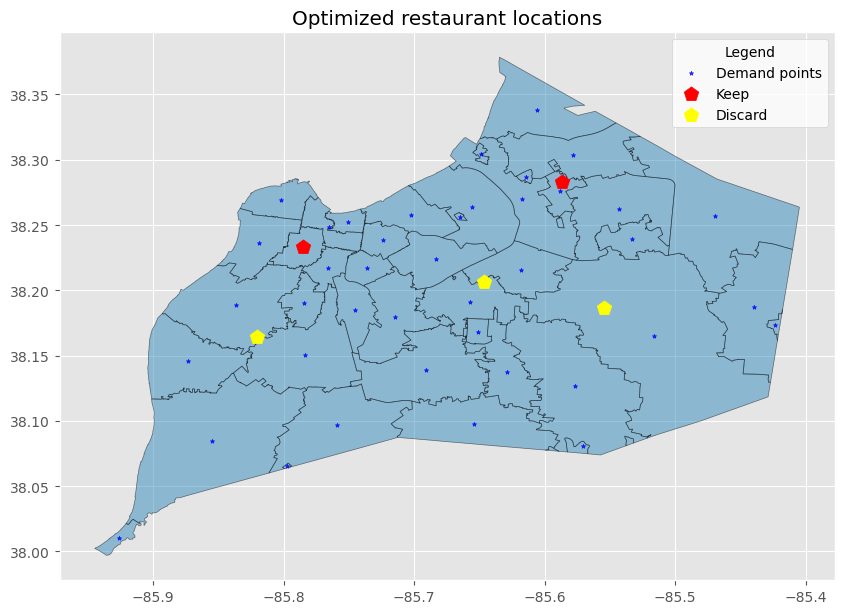

In [36]:
ax = JC.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

demand_points.plot(ax=ax, marker='*', color='blue', markersize=10, alpha=0.8, label='Demand points')

candidate_locations_df3.loc[candidate_locations_df3.decisions3 =='yes'].\
    plot(ax=ax, marker='p', color='red', markersize=120, label='Keep')

candidate_locations_df3.loc[candidate_locations_df3.decisions3 =='no'].\
    plot(ax=ax, marker='p', color='yellow', markersize=120, label='Discard')

plt.title('Optimized restaurant locations')
plt.legend(title='Legend', facecolor='white')
#plt.xticks([])
#plt.yticks([])
#plt.show()
plt.savefig('model3.png')

In [18]:
# Extract assignment variables
y_series = pd.Series(mdl3.getAttr('X', y))
y_1s = y_series[y_series > 0.5]
x_series = pd.Series(mdl3.getAttr('X', x))
x_1s = x_series[x_series > 0.5]

sol_y = pd.Series(mdl3.getAttr('X', y))
sol_y.name = 'Assignments'
sol_y.index.names = ['customer no.', 'facility no.']
assignment0 = sol_y[sol_y > 0.5].to_frame()
assignment_name = assignment0.reset_index()

# organize data
customer_df2 = pd.DataFrame(demand_points[['longitude', 'latitude']]).reset_index()
customer_df2.columns = ['customer no.', 'c_longitude', 'c_latitude']
facility_df = pd.DataFrame(candidate_locations_df3[['longitude', 'latitude']]).reset_index()
facility_df.columns = ['facility no.', 'f_longitude', 'f_latitude']
assignment2 = pd.merge(assignment_name[['customer no.', 'facility no.']],
                       facility_df[['facility no.', 'f_longitude', 'f_latitude']], on='facility no.')
assignment = pd.merge(assignment2, customer_df2[['customer no.', 'c_longitude', 'c_latitude']])

In [19]:
facility0=candidate_locations.copy()
customer_df0=demand_points.copy()

In [20]:
unique_stations = assignment['facility no.'].unique()
display(list(unique_stations))
facility0.iloc[list(unique_stations),:]

[3, 0]

,id,name,longitude,latitude,candidate_id,fac_cor,geometry
3,4,FS4,-85.587143,38.283168,Site4,"-85.5871430024028,38.2831680525277",POINT (-85.58714 38.28317)
0,1,FS1,-85.785332,38.232840,Site1,"-85.7853320204846,38.2328401755705",POINT (-85.78533 38.23284)


In [44]:
# %% Network Diagram
def draw_network_diagram(assignment, JC, facility0, customer_df0):
    us_boundary_map = JC.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
    # customer
    customer_df0.plot(ax=us_boundary_map, marker='o', color='blue', markersize='population', alpha=0.3, label='Customer')

    # Facility
    unique_stations = assignment['facility no.'].unique()
    # Plot potential facility locations as points
    facility_selected = facility0.iloc[list(unique_stations),:]
    facility_selected.plot(ax=us_boundary_map, marker='p', color='red', markersize=500, alpha=1, label='Warehouse')
    """
    for i in range(facility0.shape[0]):
        plt.text(x=facility0.latitude[i], y=facility0.longitude[i] ,
                 s=facility0.index[i] +1,
                 fontdict=dict(color='black', size=15))
    """
    # plot the line segments, indicent points, and base station points of the final network

    for ust in range(len(unique_stations)):
        d1 = assignment.loc[assignment['facility no.'] == unique_stations[ust]].reset_index()
        new_list = []
        for r in range(d1.shape[0]):
            new_list.append([(d1.c_longitude[r], d1.c_latitude[r]), (d1.f_longitude[r], d1.f_latitude[r])])
        lc = mc.LineCollection(new_list, colors=f'C{ust + 1}',
                               alpha=.7)  # alpha = (ust/len(unique_stations)), colors=ust,
        us_boundary_map.add_collection(lc)
        display(unique_stations)
    #plt.axis('off')

    #plt.show()
    #plt.savefig('Outputs/network.png', transparent=True)
    #plt.savefig('network.png', transparent=True)
    plt.savefig('network.png')


array([3, 0], dtype=int64)

array([3, 0], dtype=int64)

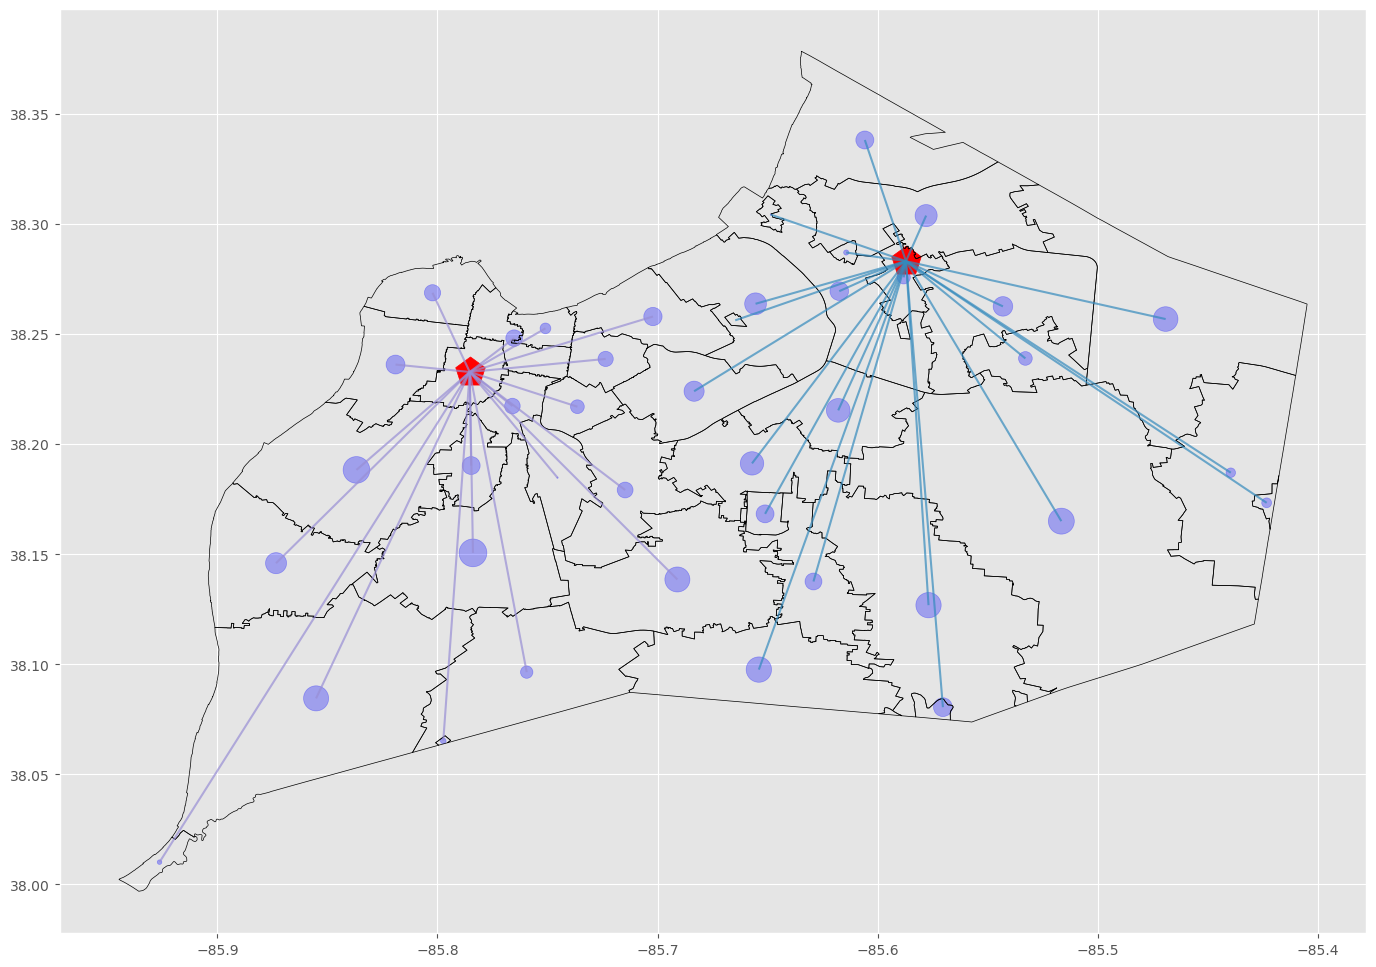

In [45]:
draw_network_diagram(assignment, JC, facility0, customer_df0)

# Model-4: Weiszfeld method for open search location problem

In [26]:
# Create a list of demand points coordinates
dem_coordinate=[]
for i in range (len(demand_points)):
    lat = demand_points["latitude"][i]
    lon = demand_points["longitude"][i]
    dem_coordinate.append([lon, lat])

points = [tuple(x) for x in dem_coordinate]

In [27]:
def weiszfeld(points):
    max_error = 0.0000000001
    lat = demand_points["latitude"]
    lon = demand_points["longitude"]

    condition = True
    start_x = (demand_points['pop'] * demand_points['longitude']).sum()/demand_points['pop'].sum()
    start_y = (demand_points['pop'] * demand_points['latitude']).sum()/demand_points['pop'].sum()

    while condition:

        norm = (((lon - start_x)**2) + ((lat - start_y)**2))**0.5

        new_x = sum(lon/norm) / sum(1/norm)
        new_y = sum(lat/norm) / sum(1/norm)

        condition = (abs(new_x - start_x) > max_error) or (abs(new_y - start_y) > max_error)

        start_y = new_y
        start_x = new_x

        print(new_x, new_y)

if __name__=="__main__":
    wz=weiszfeld(points)

In [28]:
if __name__=="__main__":
    wz=weiszfeld(points)

-85.68154705779722 38.20401362252153
-85.6840468966674 38.20834225282423
-85.68534346132834 38.21030270375682
-85.68596220644378 38.211199178736855
-85.68624604960593 38.211607688132524
-85.6863738047179 38.21179302792969
-85.6864307263435 38.21187694178005
-85.6864559211332 38.21191492793524
-85.68646701088933 38.211932141220736
-85.68647186364022 38.21193995551506
-85.68647397234976 38.21194351158561
-85.68647488054732 38.21194513472794
-85.68647526712557 38.21194587828007
-85.68647542905812 38.211946220355514
-85.68647549537131 38.21194637851784
-85.68647552163118 38.21194645207004
-85.68647553148887 38.211946486501844
-85.6864755348513 38.211946502740986
-85.68647553577553 38.211946510463655
-85.686475535868 38.21194651416966
-85.68647553573196 38.211946515965565
-85.68647553557295 38.21194651684476
-85.68647553544766 38.21194651727977
-85.68647553536168 38.21194651749731
-85.68647553530666 38.21194651760727
-85.68647553527298 38.21194651766342


In [29]:
single_facility = pd.DataFrame({'longitude':[-85.68647553527298], 'latitude':[38.21194651766342]})
single_facility = add_geocoordinates(single_facility)

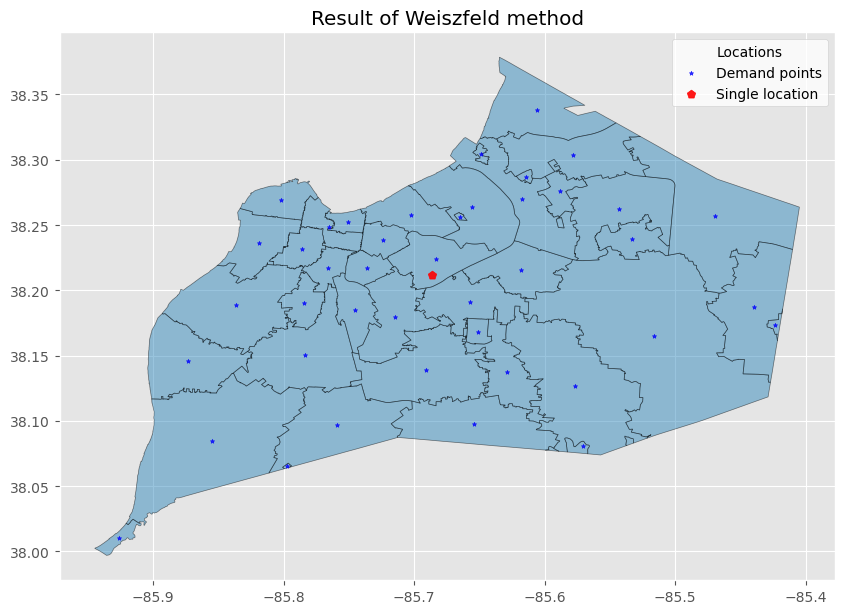

In [47]:
# Plot demand points and candidate facility locations
ax = JC.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
demand_points.plot(ax=ax, marker='*', color='blue', markersize=10, alpha=0.8, label='Demand points')
single_facility.plot(ax=ax, marker='p', color='red', markersize=40, alpha=0.9, label='Single location')

plt.legend(facecolor='white', title='Locations')
plt.title('Result of Weiszfeld method')
plt.savefig('model4.png')